In [43]:
import nltk
import spacy
import time
import os
import io
import numpy as np
from sltk import sltk
import transformers
from transformers import BertTokenizer
from tokenizers import BertWordPieceTokenizer
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Redline
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
!python -m spacy download xx_ent_wiki_sm

In [4]:
# load the corpus
with open("data/sin.csv", "r") as f:
    corpus = f.read()

In [34]:
# NLTK tokenization
def nltk_tokenizer():
    start_time = time.time()
    nltk_tokens = nltk.word_tokenize(corpus)
    nltk_time = time.time() - start_time
    nltk_compression = len(nltk_tokens) / (len(corpus) + len(nltk_tokens))
    print("NLTK: Time = {:.2f}s, Compression = {:.2f}".format(nltk_time, nltk_compression))
    return nltk_time, nltk_compression, len(nltk_tokens)

In [35]:
nltk_time, nltk_compression, nltk_tokens = nltk_tokenizer()
print(nltk_time, nltk_compression, nltk_tokens)

NLTK: Time = 2.09s, Compression = 0.16
2.0948598384857178 0.1587360958262467 279246


In [36]:
# spaCy tokenization
def spacy_tokenizer():
    spacy_nlp = spacy.load("xx_ent_wiki_sm")
    start_time = time.time()
    spacy_nlp.max_length = 1_500_000
    spacy_doc = spacy_nlp(corpus)
    spacy_tokens = [token.text for token in spacy_doc]
    spacy_time = time.time() - start_time
    spacy_compression = len(spacy_tokens) / (len(corpus) + len(spacy_tokens))
    print("spaCy: Time = {:.2f}s, Compression = {:.2f}".format(spacy_time, spacy_compression))
    return spacy_time, spacy_compression, len(spacy_tokens)

In [37]:
spacy_time, spacy_compression, spacy_tokens = spacy_tokenizer()
print(spacy_time, spacy_compression)

spaCy: Time = 23.87s, Compression = 0.17
23.865596294403076 0.1700824624909224


In [53]:
# BERT tokenization
def bertTokenizer():
    start_time = time.time()
    # initialize
    tokenizer = BertWordPieceTokenizer(
        clean_text=True,
        handle_chinese_chars=False,
        strip_accents=False,
        lowercase=False
    )
    # and train
    tokenizer.train(files='data/sin.csv', vocab_size=30_000, min_frequency=2,
                    limit_alphabet=1000, wordpieces_prefix='##',
                    special_tokens=[
                        '[PAD', '[UNK]', '[CLS]', '[SEP]', '[MASK]'])

    # os.mkdir('./bert')

    tokenizer.save_model('./bert', 'bert')

    # tokenize
    tokenizer = BertTokenizer.from_pretrained("./bert")
    bert_tokens = tokenizer.tokenize(corpus)
    bert_time = time.time() - start_time
    bert_compression = len(bert_tokens) / (len(corpus) + len(bert_tokens))
    print("BERT: Time = {:.2f}s, Compression = {:.2f}".format(bert_time, bert_compression))
    # print(bert_tokens)
    return bert_time, bert_compression, len(bert_tokens)

In [54]:
bert_time, bert_compression, bert_tokens = bertTokenizer()
print(bert_time, bert_compression)

BERT: Time = 6.04s, Compression = 0.16
6.040222883224487 0.16251699086539387


In [47]:
# sltk tokenizer
def sltTokenizer():
    start_time = time.time()

    sentences = sltk.splitSentences(corpus)
    sltk_tokens = sltk.buildVocab(sentences)
    f = open("models/vocab.txt", "w")
    f.write('\n'.join(sltk_tokens))
    f.close()

    #tokenize
    # sltk_tokens = sltk.tokenize('models/vocab.txt', sentences)
    sltk_time = time.time() - start_time
    sltk_compression = len(sltk_tokens) / (len(corpus) + len(sltk_tokens))
    print("SLTK: Time = {:.2f}s, Compression = {:.2f}".format(sltk_time, sltk_compression))
    return sltk_time, sltk_compression, len(sltk_tokens)

In [48]:
sltk_time, sltk_compression, sltk_tokens = sltTokenizer()
print(sltk_time, sltk_compression)

Dictionary Lookup: 100%|##########| 7/7 [00:00<00:00, 634.37it/s]
Masking Emails: 0it [00:00, ?it/s]
Generating Vocab: 100%|##########| 7060/7060 [00:00<00:00, 20455.43it/s]

Found 7049 unique tokens out of 7060 tokens.
Total 7209 Tokens
SLTK: Time = 6.41s, Compression = 0.00
6.409219741821289 0.00484753692809117


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


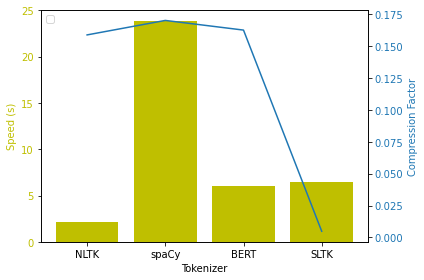

In [55]:
# Plot the results
speed = [nltk_time, spacy_time, bert_time, sltk_time]
compression = [nltk_compression, spacy_compression, bert_compression, sltk_compression]
tokenizers = ["NLTK", "spaCy", "BERT", "SLTK"]

fig, ax1 = plt.subplots()

color = "y"
ax1.set_xlabel("Tokenizer")
ax1.set_ylabel("Speed (s)", color=color)
ax1.bar(tokenizers, speed, color=color)
ax1.tick_params(axis="y", labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "tab:blue"
ax2.set_ylabel("Compression Factor", color=color)  # we already handled the x-label with ax1
ax2.plot(tokenizers, compression, color=color)
ax2.legend(loc="upper left")
ax2.tick_params(axis="y", labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

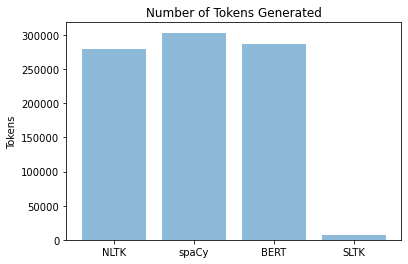

In [56]:
objects = ("NLTK", "spaCy", "BERT", "SLTK")
y_pos = np.arange(len(objects))
performance = [nltk_tokens, spacy_tokens, bert_tokens, sltk_tokens]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Tokens')
plt.title('Number of Tokens Generated')

plt.show()